In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2022)

In [2]:
# Data
titanic = pd.read_csv("simple_titanic.csv")

In [3]:
titanic.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked'], dtype='object')

In [4]:
# 예측할 값 Survived를 label에 할당, data에서 제거
label = titanic["Survived"]
data = titanic.drop(["Survived"], axis=1)

In [5]:
# Data EDA
data.describe()
# Sex와 Embarked는 범주형 변수

,Pclass,Age,Fare
count,1306.000000,1043.000000,1306.000000
mean,2.296325,29.813202,33.223956
std,0.837037,14.366254,51.765986
min,1.000000,0.170000,0.000000
25%,2.000000,21.000000,7.895800
50%,3.000000,28.000000,14.454200
75%,3.000000,39.000000,31.275000
max,3.000000,80.000000,512.329200


In [6]:
data["Sex"].value_counts()

male      842
female    464
Name: Sex, dtype: int64

In [7]:
data["Embarked"].value_counts()

S    913
C    270
Q    123
Name: Embarked, dtype: int64

In [8]:
# 결측치 확인
data.isna().sum()

Pclass        0
Sex           0
Age         263
Fare          0
Embarked      0
dtype: int64

In [9]:
label.value_counts()
# 0이 생존X, 1이 생존

0    814
1    492
Name: Survived, dtype: int64

In [10]:
# Data Preprocess
# 범주형 변수를 정수로 변환
data.loc[:, "Sex"] = data["Sex"].map({"male": 0, "female": 1})
data.loc[:, "Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

In [11]:
# Data Split
from sklearn.model_selection import train_test_split

# train, valid
train_data, validation_data, train_label, validation_label = train_test_split(data, label, train_size=0.6, random_state=2022)

In [12]:
# valid, test
valid_data, test_data, valid_label, test_label = train_test_split(validation_data, validation_label, train_size=0.5, random_state=2022)

In [13]:
# 6:2:2로 data split
print(f"train_data size: {len(train_label)}, {len(train_label)/len(data):.2f}")
print(f"valid_data size: {len(valid_label)}, {len(valid_label)/len(data):.2f}")
print(f"test_data size: {len(test_label)}, {len(test_label)/len(data):.2f}")

train_data size: 783, 0.60
valid_data size: 261, 0.20
test_data size: 262, 0.20


In [14]:
# for pandas data index reset
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_label = train_label.reset_index(drop=True)
valid_label = valid_label.reset_index(drop=True)
test_label = test_label.reset_index(drop=True)

In [15]:
# 빈 데이터 채우기 3가지 방법
na_cnt = data.isna().sum()
na_cnt.loc[na_cnt > 0].index

Index(['Age'], dtype='object')

In [16]:
# 사용하지 않는 방법
drop_data = data.dropna()

In [17]:
print(f"전체 데이터 개수: {len(data)}")
print(f"값이 비어있는 데이터를 버린 후 데이터 개수: {len(drop_data)}")
print(f"버려진 데이터 개수: {len(data) - len(drop_data)}")

전체 데이터 개수: 1306
값이 비어있는 데이터를 버린 후 데이터 개수: 1043
버려진 데이터 개수: 263


In [18]:
# 전체 데이터의 평균으로 채우는 방법
# 데이터 복사
mean_train_data = train_data.copy()
mean_valid_data = valid_data.copy()
mean_test_data = test_data.copy()

In [19]:
# 빈 값이 있는 train data의 age의 평균
age_mean = mean_train_data["Age"].mean()
age_mean

30.13604100946372

In [20]:
# 빈 데이터 채우기
mean_train_data.loc[:, "Age"] = mean_train_data["Age"].fillna(age_mean)
mean_valid_data.loc[:, "Age"] = mean_valid_data["Age"].fillna(age_mean)
mean_test_data.loc[:, "Age"] = mean_test_data["Age"].fillna(age_mean)

In [21]:
# 빈 데이터 수 zero
mean_train_data.isna().sum()

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
dtype: int64

In [22]:
# 비슷한 데이터의 평균으로 채우는 방법
cluster_train_data = train_data.copy()
cluster_valid_data = valid_data.copy()
cluster_test_data = test_data.copy()

In [23]:
# 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cluster_train_data.drop(["Age"], axis=1))

StandardScaler()

In [24]:
train_fill_data = scaler.transform(cluster_train_data.drop(["Age"], axis=1))
valid_fill_data = scaler.transform(cluster_valid_data.drop(["Age"], axis=1))
test_fill_data = scaler.transform(cluster_test_data.drop(["Age"], axis=1))

In [25]:
# K값에 따른 SSE를 그려서 최적의 K값 찾기
from sklearn.cluster import KMeans

n_cluster = []
sse = []
for n in range(3, 15, 2):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(train_fill_data)
    n_cluster += [n]
    sse += [kmeans.inertia_]

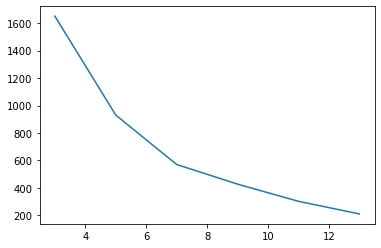

In [26]:
plt.plot(n_cluster, sse)

In [27]:
# K = 7
n_clusters = 7

In [28]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(train_fill_data)

KMeans(n_clusters=7)

In [29]:
clustered_train = kmeans.predict(train_fill_data)
clustered_valid = kmeans.predict(valid_fill_data)
clustered_test = kmeans.predict(test_fill_data)

In [57]:
# train data가 어떤 군집에 속할 지 확인 0~6
clustered_train

array([5, 5, 0, 1, 5, 0, 0, 3, 0, 0, 6, 1, 0, 0, 5, 0, 1, 1, 5, 1, 6, 0,
       3, 0, 1, 3, 5, 3, 0, 1, 4, 2, 0, 1, 0, 0, 6, 3, 1, 0, 1, 0, 3, 5,
       3, 3, 0, 3, 4, 3, 5, 0, 0, 0, 1, 1, 4, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       3, 1, 5, 1, 2, 0, 1, 3, 0, 0, 1, 1, 0, 3, 1, 1, 3, 2, 0, 6, 0, 0,
       4, 1, 6, 0, 6, 0, 0, 2, 0, 5, 0, 1, 1, 0, 5, 2, 6, 0, 1, 3, 3, 3,
       3, 4, 0, 0, 0, 2, 2, 2, 5, 1, 0, 4, 0, 2, 2, 6, 0, 4, 0, 5, 0, 5,
       3, 0, 3, 0, 0, 6, 0, 2, 3, 0, 0, 2, 2, 1, 3, 3, 0, 0, 2, 2, 6, 0,
       0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 1, 3, 5, 5, 0, 0, 6,
       5, 6, 0, 0, 0, 5, 0, 3, 0, 4, 3, 6, 0, 0, 3, 0, 6, 5, 2, 0, 1, 5,
       5, 0, 1, 5, 0, 6, 0, 3, 6, 0, 4, 0, 3, 0, 6, 0, 3, 6, 3, 6, 3, 5,
       3, 3, 3, 1, 6, 1, 1, 1, 2, 0, 1, 3, 6, 1, 1, 3, 3, 1, 2, 5, 0, 0,
       0, 3, 0, 0, 5, 0, 0, 0, 1, 3, 0, 1, 3, 1, 2, 3, 3, 2, 0, 0, 3, 1,
       3, 6, 0, 0, 0, 0, 3, 6, 0, 4, 0, 0, 0, 1, 1, 0, 0, 0, 3, 6, 5, 3,
       0, 6, 0, 0, 3, 0, 2, 0, 2, 0, 3, 3, 5, 0, 0,

In [31]:
cluster_fill_value = {}
for i in range(n_clusters):
    class_mean = cluster_train_data.loc[clustered_train == i, "Age"].dropna().mean()
    cluster_fill_value[i] = class_mean

In [32]:
cluster_fill_value

{0: 27.871728395061727,
 1: 40.46551724137931,
 2: 21.666666666666668,
 3: 24.838064516129034,
 4: 41.404761904761905,
 5: 29.25,
 6: 37.17910447761194}

In [33]:
train_na_idx = cluster_train_data.loc[cluster_train_data["Age"].isna()].index

In [34]:
# 빈 값이 있는 데이터들의 index
# 총 149개 data가 train data에서 빈 값이 있음
train_na_idx

Int64Index([  2,   3,   9,  17,  26,  31,  41,  49,  53,  68,
            ...
            727, 732, 733, 742, 747, 754, 760, 764, 766, 777],
           dtype='int64', length=149)

In [35]:
# 각 index가 속하는 군집
clustered_train[train_na_idx]

array([0, 1, 0, 1, 5, 2, 0, 3, 0, 5, 1, 1, 3, 1, 0, 2, 5, 5, 0, 0, 2, 2,
       0, 4, 5, 0, 0, 0, 5, 5, 5, 0, 0, 5, 1, 5, 0, 6, 3, 1, 6, 1, 2, 1,
       1, 1, 0, 0, 5, 0, 2, 3, 0, 0, 0, 1, 0, 2, 6, 3, 0, 3, 2, 0, 0, 5,
       0, 3, 6, 5, 5, 5, 0, 6, 2, 0, 0, 2, 6, 5, 1, 6, 2, 2, 4, 3, 5, 5,
       2, 0, 2, 5, 3, 6, 5, 2, 5, 1, 0, 0, 5, 5, 0, 0, 2, 5, 2, 2, 6, 5,
       2, 1, 2, 5, 5, 2, 5, 0, 0, 1, 0, 5, 5, 5, 0, 0, 5, 0, 1, 0, 0, 3,
       5, 3, 0, 5, 0, 3, 5, 1, 0, 5, 0, 6, 3, 1, 1, 5, 5])

In [36]:
train_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_train[train_na_idx]))

In [37]:
train_fill_value[:10]

[27.871728395061727,
 40.46551724137931,
 27.871728395061727,
 40.46551724137931,
 29.25,
 21.666666666666668,
 27.871728395061727,
 24.838064516129034,
 27.871728395061727,
 29.25]

In [38]:
# train data 채우기
cluster_train_data.loc[train_na_idx, "Age"] = train_fill_value

In [39]:
# 원래 있던 값
cluster_train_data.loc[train_na_idx]

,Pclass,Sex,Age,Fare,Embarked
2,3,0,27.871728,69.5500,0
3,1,0,40.465517,30.5000,0
9,3,0,27.871728,7.8792,0
17,1,0,40.465517,25.9250,0
26,3,0,29.250000,15.5000,2
...,...,...,...,...,...
754,3,1,24.838065,14.5000,0
760,1,0,40.465517,0.0000,0
764,1,0,40.465517,27.7208,1
766,3,0,29.250000,6.8583,2


In [40]:
# 채워준 값
cluster_train_data.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,0,21.000000,7.2250,1
1,3,0,34.500000,6.4375,1
2,3,0,27.871728,69.5500,0
3,1,0,40.465517,30.5000,0
4,3,0,20.000000,4.0125,1


In [41]:
# vaild, test data 채우기 (train data에서 학습된 값으로 채움)
valid_na_idx = cluster_valid_data.loc[cluster_valid_data["Age"].isna()].index
valid_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_valid[valid_na_idx]))

test_na_idx = cluster_test_data.loc[cluster_test_data["Age"].isna()].index
test_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_test[test_na_idx]))

In [42]:
cluster_valid_data.loc[valid_na_idx, "Age"] = valid_fill_value
cluster_test_data.loc[test_na_idx, "Age"] = test_fill_value

In [43]:
# 학습 모델
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [44]:
# Hyper-parameter tuning
# 전체 데이터의 평균으로 채운 데이터
n_estimators = [n for n in range(50, 1050, 50)]

mean_accuracy = []
for n_estimator in n_estimators:
    mean_random_forest = RandomForestClassifier(n_estimators=n_estimator)
    mean_random_forest.fit(mean_train_data, train_label)
    mean_valid_pred = mean_random_forest.predict(mean_valid_data)
    mean_accuracy += [accuracy_score(valid_label, mean_valid_pred)]

In [45]:
list(zip(n_estimators, mean_accuracy))

[(50, 0.8659003831417624),
 (100, 0.8390804597701149),
 (150, 0.8582375478927203),
 (200, 0.8505747126436781),
 (250, 0.8544061302681992),
 (300, 0.8582375478927203),
 (350, 0.8582375478927203),
 (400, 0.8544061302681992),
 (450, 0.8582375478927203),
 (500, 0.8620689655172413),
 (550, 0.8582375478927203),
 (600, 0.8582375478927203),
 (650, 0.8544061302681992),
 (700, 0.8582375478927203),
 (750, 0.8544061302681992),
 (800, 0.8582375478927203),
 (850, 0.8620689655172413),
 (900, 0.8582375478927203),
 (950, 0.8582375478927203),
 (1000, 0.8582375478927203)]

In [46]:
mean_best_n_estimator = n_estimators[np.argmax(mean_accuracy)]

In [47]:
print(f"Best n_estimator for mean data is {mean_best_n_estimator}, it's valid accuracy is {max(mean_accuracy):.4f}")

Best n_estimator for mean data is 50, it's valid accuracy is 0.8659


In [48]:
# 비슷한 데이터들의 평균으로 채운 데이터
cluster_accuracy = []
for n_estimator in n_estimators:
    cluster_random_forest = RandomForestClassifier(n_estimators=n_estimator)
    cluster_random_forest.fit(cluster_train_data, train_label)
    cluster_valid_pred = cluster_random_forest.predict(cluster_valid_data)
    cluster_accuracy += [accuracy_score(valid_label, cluster_valid_pred)]

In [49]:
list(zip(n_estimators, cluster_accuracy))

[(50, 0.8544061302681992),
 (100, 0.8582375478927203),
 (150, 0.8620689655172413),
 (200, 0.8544061302681992),
 (250, 0.8620689655172413),
 (300, 0.8582375478927203),
 (350, 0.8620689655172413),
 (400, 0.8505747126436781),
 (450, 0.8544061302681992),
 (500, 0.8582375478927203),
 (550, 0.8620689655172413),
 (600, 0.8505747126436781),
 (650, 0.8582375478927203),
 (700, 0.8582375478927203),
 (750, 0.8620689655172413),
 (800, 0.8505747126436781),
 (850, 0.8620689655172413),
 (900, 0.8582375478927203),
 (950, 0.8544061302681992),
 (1000, 0.8544061302681992)]

In [50]:
cluster_best_n_estimator = n_estimators[np.argmax(cluster_accuracy)]

In [51]:
print(f"Best n_estimator for cluster data is {cluster_best_n_estimator}, it's valid accuracy is {max(cluster_accuracy):.4f}")

Best n_estimator for cluster data is 150, it's valid accuracy is 0.8621


In [52]:
# Best Parameter
mean_random_forest = RandomForestClassifier(n_estimators=mean_best_n_estimator)
cluster_random_forest = RandomForestClassifier(n_estimators=cluster_best_n_estimator)

In [53]:
# 학습
mean_random_forest.fit(mean_train_data, train_label)
cluster_random_forest.fit(cluster_train_data, train_label)

RandomForestClassifier(n_estimators=150)

In [54]:
# 예측
mean_test_pred = mean_random_forest.predict(mean_test_data)
cluster_test_pred = cluster_random_forest.predict(cluster_test_data)

In [55]:
# 평가
mean_test_accuracy = accuracy_score(test_label, mean_test_pred)
cluster_test_accuracy = accuracy_score(test_label, cluster_test_pred)

In [56]:
print(f"Test Accuracy for mean data is {mean_test_accuracy:.4f}")
print(f"Test Accuracy for cluster data is {cluster_test_accuracy:.4f}")

Test Accuracy for mean data is 0.8511
Test Accuracy for cluster data is 0.8626
